In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# We will visualize the messages with a word cloud
from wordcloud import WordCloud

# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Import the train test split
from sklearn.model_selection import train_test_split

# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

In [3]:
# Load the data
data = pd.read_csv('train.csv')

In [4]:
# Display firt five rows
display(data.head())

# Display the summary statistics
display(data.describe())

# Print the info
print(data.info())

,Unnamed: 0,title,text,subject,date,label
0,0,"Boiler Room EP #75 – Limited Hangouts, Syria a...",Tune in to the Alternate Current Radio Network...,US_News,"September 21, 2016",0
1,1,WATCH: KIM JONG-UN Blows Up US Aircraft Carrie...,President @realDonaldTrump: I inherited a mes...,politics,"Mar 21, 2017",0
2,2,\r\r\r\r\r\r\r\nWATCH: Democratic Rep Delivers...,Massachusetts Rep. Jim McGovern brought the Ho...,News,"May 4, 2017",0
3,3,DISASTER CAPITALISTS: How Bill And Hillary’s “...,Hillary was Secretary of State an unimaginable...,politics,"Oct 7, 2016",0
4,4,OBAMA AND VALERIE JARRETT Finalize Executive A...,It s almost as though we don t even have a Con...,Government News,"Dec 11, 2015",0


,Unnamed: 0,label
count,17959.000000,17959.000000
mean,8979.000000,0.480261
std,5184.461078,0.499624
min,0.000000,0.000000
25%,4489.500000,0.000000
50%,8979.000000,0.000000
75%,13468.500000,1.000000
max,17958.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17959 entries, 0 to 17958
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  17959 non-null  int64 
 1   title       17959 non-null  object
 2   text        17959 non-null  object
 3   subject     17959 non-null  object
 4   date        17959 non-null  object
 5   label       17959 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 842.0+ KB
None


label
0    420.281016
1    386.715478
Name: word_count, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


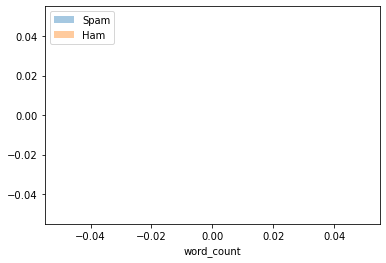

In [5]:
# Store the number of words in each messages
data['word_count'] = data['text'].str.split().str.len()

# Print the average number of words in each category
print(data.groupby('label')['word_count'].mean())

# Visualize the distribution of word counts in each category
sns.distplot(data[data['label']=='spam']['word_count'], label='Spam')
sns.distplot(data[data['label']=='ham']['word_count'], label='Ham'),
plt.legend()
plt.show()

In [6]:
# Make the letters lower case and tokenize the words
tokenized_texts = data['text'].str.lower().apply(word_tokenize)

# Print the tokens to see how it looks like
print(tokenized_texts)

0        [tune, in, to, the, alternate, current, radio,...
1        [president, @, realdonaldtrump, :, i, inherite...
2        [massachusetts, rep., jim, mcgovern, brought, ...
3        [hillary, was, secretary, of, state, an, unima...
4        [it, s, almost, as, though, we, don, t, even, ...
                               ...                        
17954    [washington, (, reuters, ), -, time, magazine,...
17955    [21st, century, wire, says, science, fiction, ...
17956    [no, matter, which, candidate, you, re, pullin...
17957    [after, president, trump, pulled, out, of, the...
17958    [donald, trump, supporter, scott, baio, has, f...
Name: text, Length: 17959, dtype: object


In [7]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(alpha)

print(tokenized_texts)

0        [tune, in, to, the, alternate, current, radio,...
1        [president, realdonaldtrump, i, inherited, a, ...
2        [massachusetts, jim, mcgovern, brought, the, h...
3        [hillary, was, secretary, of, state, an, unima...
4        [it, s, almost, as, though, we, don, t, even, ...
                               ...                        
17954    [washington, reuters, time, magazine, named, d...
17955    [century, wire, says, science, fiction, is, no...
17956    [no, matter, which, candidate, you, re, pullin...
17957    [after, president, trump, pulled, out, of, the...
17958    [donald, trump, supporter, scott, baio, has, f...
Name: text, Length: 17959, dtype: object


In [8]:
# Define a function to remove stop words
def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(remove_stop_words)

print(tokenized_texts)

0        [tune, alternate, current, radio, network, acr...
1        [president, realdonaldtrump, inherited, mess, ...
2        [massachusetts, jim, mcgovern, brought, house,...
3        [hillary, secretary, state, unimaginable, eart...
4        [almost, though, even, constitution, never, le...
                               ...                        
17954    [washington, reuters, time, magazine, named, d...
17955    [century, wire, says, science, fiction, scienc...
17956    [matter, candidate, pulling, democratic, presi...
17957    [president, trump, pulled, paris, accord, left...
17958    [donald, trump, supporter, scott, baio, filed,...
Name: text, Length: 17959, dtype: object


In [9]:
# Define a function to lemmatization
def lemmatize(tokens):
    """This function lemmatize the messages"""
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(lemmatize)

print(tokenized_texts)

0        tune alternate current radio network acr anoth...
1        president realdonaldtrump inherited mess mess ...
2        massachusetts jim mcgovern brought house scath...
3        hillary secretary state unimaginable earthquak...
4        almost though even constitution never let cris...
                               ...                        
17954    washington reuters time magazine named donald ...
17955    century wire say science fiction science video...
17956    matter candidate pulling democratic presidenti...
17957    president trump pulled paris accord left went ...
17958    donald trump supporter scott baio filed police...
Name: text, Length: 17959, dtype: object


In [10]:
# Replace the columns with tokenized messages
data['text'] = tokenized_texts

# Display the first five rows
display(data.head())

,Unnamed: 0,title,text,subject,date,label,word_count
0,0,"Boiler Room EP #75 – Limited Hangouts, Syria a...",tune alternate current radio network acr anoth...,US_News,"September 21, 2016",0,134
1,1,WATCH: KIM JONG-UN Blows Up US Aircraft Carrie...,president realdonaldtrump inherited mess mess ...,politics,"Mar 21, 2017",0,278
2,2,\r\r\r\r\r\r\r\nWATCH: Democratic Rep Delivers...,massachusetts jim mcgovern brought house scath...,News,"May 4, 2017",0,576
3,3,DISASTER CAPITALISTS: How Bill And Hillary’s “...,hillary secretary state unimaginable earthquak...,politics,"Oct 7, 2016",0,96
4,4,OBAMA AND VALERIE JARRETT Finalize Executive A...,almost though even constitution never let cris...,Government News,"Dec 11, 2015",0,206


In [11]:
# Select the features and the target
X = data['text']
y = data['label']



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)
X_train

5124     moscow reuters russia quietly boosting economi...
13716    washington reuters republican presidential can...
7427     democratic senator dianne feinstein told feder...
6828                                                      
11538    heading cape cod next end people optic awful h...
                               ...                        
11810    baghdad reuters kurdistan regional government ...
1219     venue new jersey new york pennsylvania califor...
8333     pandering like crazy see people stuck play vic...
1568     last chance turn conservative ship around put ...
1761     norm donald trump clear absolutely preparation...
Name: text, Length: 14367, dtype: object

In [13]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)



In [14]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
print("Accuracy:",nb.score(tfidf_test, y_test))

Accuracy: 0.9273385300668151


Confusion Matrix

[[1729  138]
 [ 123 1602]]


Classification Report

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1867
           1       0.92      0.93      0.92      1725

    accuracy                           0.93      3592
   macro avg       0.93      0.93      0.93      3592
weighted avg       0.93      0.93      0.93      3592


ROC AUC Score: 0.9273901399594792


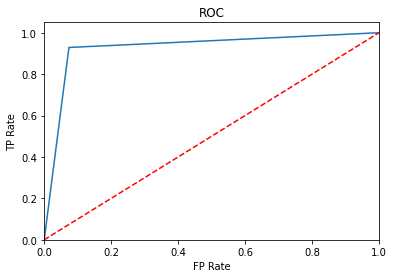

In [15]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)


# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:",auc_score)

# Get probabilities.
y_pred_proba = nb.predict(tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Visualize the ROC curve.
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.show()

https://www.kaggle.com/barishasdemir/classification-with-naive-bayes